# Initial Encodings

In [13]:
from helper_functions import reduce_mem_usage
import pandas as pd
train_dir=r'C:\Users\jithi\OneDrive\Desktop\ML project\microsoft-malware-prediction\train.csv'
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float32',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float32',
        'AVProductsEnabled':                                    'float32',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float32',
        'GeoNameIdentifier':                                    'float32',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float32',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float32',
        'IeVerIdentifier':                                      'float32',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float32',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float32',
        'Census_ProcessorManufacturerIdentifier':               'float32',
        'Census_ProcessorModelIdentifier':                      'float32',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float32',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float32',
        'Census_IsFlightsDisabled':                             'float32',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float32',
        'Census_FirmwareManufacturerIdentifier':                'float32',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float32',
        'Census_IsVirtualDevice':                               'float32',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float32',
        'Wdft_IsGamer':                                         'float32',
        'Wdft_RegionIdentifier':                                'float32',
        'HasDetections':                                        'int8'
        }
#split into train and validation sets
train = pd.read_csv(train_dir, dtype=dtypes)
train = reduce_mem_usage(train)
train.drop(columns=['MachineIdentifier'], inplace=True)

Mem. usage decreased to 2300.96 Mb (16.6% reduction)


In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from optuna.integration import XGBoostPruningCallback
y=train['HasDetections']

X=train.drop(columns=['HasDetections'], inplace=True)
# Assuming X, y are your dataset features and labels
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Use 30% of training set for faster tuning (subsample for hyperparameter optimization)
X_sub, _, y_sub, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42, stratify=y_train)

dtrain = xgb.DMatrix(X_sub, label=y_sub, enable_categorical=True)
dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)

# Set parameters including GPU for training
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 600),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_categorical('subsample', [0.45, 0.6, 0.75, 0.9, 1.0]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-5, 0.5, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'max_leaves': trial.suggest_int('max_leaves', 31, 255),
        'max_bin': trial.suggest_int('max_bin', 128, 512),
        'enable_categorical': True,
        'random_state': 42,
    }

    # Create the model
    model = xgb.XGBClassifier(**params,device='cuda')
    
    # Fit the model without early stopping or callbacks
    model.fit(
        X_sub, y_sub,
        verbose=False
    )
    
    # Get predictions
    preds = model.predict_proba(X_valid)[:, 1]
    
    # Return log loss to optimize
    return log_loss(y_valid, preds)

# Run optimization
study = optuna.create_study(direction='minimize', study_name='XGBoost Hyperparameter Optimization')
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Best trial
print("Best trial:")
print(study.best_trial)
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

[I 2025-04-19 11:58:16,169] A new study created in memory with name: XGBoost Hyperparameter Optimization


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-04-19 11:59:00,081] Trial 0 finished with value: 0.6219674868591651 and parameters: {'n_estimators': 514, 'max_depth': 5, 'learning_rate': 0.02037466238777455, 'subsample': 0.45, 'colsample_bytree': 0.7796401089656948, 'colsample_bynode': 0.8800322769857565, 'gamma': 5.897614230730974e-05, 'min_child_weight': 3, 'reg_lambda': 4.950013603286138, 'reg_alpha': 0.001311961636507008, 'grow_policy': 'depthwise', 'max_leaves': 114, 'max_bin': 445}. Best is trial 0 with value: 0.6219674868591651.
[I 2025-04-19 11:59:40,003] Trial 1 finished with value: 0.6165504400373699 and parameters: {'n_estimators': 439, 'max_depth': 5, 'learning_rate': 0.037706796781389704, 'subsample': 0.75, 'colsample_bytree': 0.6513903070057545, 'colsample_bynode': 0.9645614396888363, 'gamma': 2.2313468867041974e-05, 'min_child_weight': 14, 'reg_lambda': 0.3237793323157197, 'reg_alpha': 0.8010843448891202, 'grow_policy': 'lossguide', 'max_leaves': 242, 'max_bin': 209}. Best is trial 1 with value: 0.616550440037

In [18]:
import xgboost as xgb
from sklearn.metrics import log_loss, classification_report, accuracy_score

best_params = {
    'n_estimators': 597,
    'max_depth': 6,
    'learning_rate': 0.12939973492374057,
    'subsample': 0.6,
    'colsample_bytree': 0.6101612967495041,
    'colsample_bynode': 0.6831244455585321,
    'gamma': 0.21891378573102319,
    'min_child_weight': 15,
    'reg_lambda': 0.49273755063719143,
    'reg_alpha': 0.12253399812402466,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'max_bin': 288,
    'enable_categorical': True,
    'random_state': 42
}

model = xgb.XGBClassifier(**best_params, device='cuda')
model.fit(X_train, y_train, verbose=True)

y_pred = model.predict_proba(X_valid)[:, 1]
log_loss_value = log_loss(y_valid, y_pred)

y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_pred_label = model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_pred_label)

print(f'Log Loss on validation set: {log_loss_value}')

print("Classification Report:\n", classification_report(y_valid, y_pred_label))
print("Training Accuracy:", train_accuracy)

print("Accuracy Score on validation set:", valid_accuracy)



c:\Users\jithi\anaconda3\envs\fai_labs_3.10\lib\site-packages\xgboost\core.py:729: UserWarning: [16:44:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Log Loss on validation set: 0.6057164076130728
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.66    893061
           1       0.66      0.66      0.66    891236

    accuracy                           0.66   1784297
   macro avg       0.66      0.66      0.66   1784297
weighted avg       0.66      0.66      0.66   1784297

Training Accuracy: 0.6687625907465491
Accuracy Score on validation set: 0.6617076641388737


In [ ]:
model.save_model('xgboost_initial_encodings.json')

# Advanced Encodings

### XGBoost

In [2]:
dtypes = {
    'ProductName':                                                  'float32',
    'IsBeta':                                                       'float32',
    'RtpStateBitfield':                                             'float32',
    'IsSxsPassiveMode':                                             'float32',
    'DefaultBrowsersIdentifier':                                    'float32',
    'AVProductStatesIdentifier':                                    'float32',
    'AVProductsInstalled':                                          'float32',
    'AVProductsEnabled':                                            'float32',
    'HasTpm':                                                       'float32',
    'CountryIdentifier':                                            'float32',
    'CityIdentifier':                                               'float32',
    'OrganizationIdentifier':                                       'float32',
    'GeoNameIdentifier':                                            'float32',
    'LocaleEnglishNameIdentifier':                                  'float32',
    'Platform':                                                     'float32',
    'Processor':                                                    'float32',
    'OsVer':                                                        'float32',
    'OsBuild':                                                      'float32',
    'OsSuite':                                                      'float32',
    'OsPlatformSubRelease':                                         'float32',
    'OsBuildLab':                                                   'float32',
    'SkuEdition':                                                   'float32',
    'IsProtected':                                                  'float32',
    'AutoSampleOptIn':                                              'float32',
    'PuaMode':                                                      'float32',
    'SMode':                                                        'float32',
    'IeVerIdentifier':                                              'float32',
    'SmartScreen':                                                  'float32',
    'Firewall':                                                     'float32',
    'UacLuaenable':                                                 'float32',
    'Census_MDC2FormFactor':                                        'float32',
    'Census_DeviceFamily':                                          'float32',
    'Census_OEMNameIdentifier':                                     'float32',
    'Census_OEMModelIdentifier':                                    'float32',
    'Census_ProcessorCoreCount':                                    'float32',
    'Census_ProcessorManufacturerIdentifier':                       'float32',
    'Census_ProcessorModelIdentifier':                              'float32',
    'Census_ProcessorClass':                                        'float32',
    'Census_PrimaryDiskTotalCapacity':                              'float32',
    'Census_PrimaryDiskTypeName':                                   'float32',
    'Census_SystemVolumeTotalCapacity':                             'float32',
    'Census_HasOpticalDiskDrive':                                   'float32',
    'Census_TotalPhysicalRAM':                                      'float32',
    'Census_ChassisTypeName':                                       'float32',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches':            'float32',
    'Census_InternalPrimaryDisplayResolutionHorizontal':            'float32',
    'Census_InternalPrimaryDisplayResolutionVertical':              'float32',
    'Census_PowerPlatformRoleName':                                 'float32',
    'Census_InternalBatteryType':                                   'float32',
    'Census_InternalBatteryNumberOfCharges':                        'float32',
    'Census_OSArchitecture':                                        'float32',
    'Census_OSBranch':                                              'float32',
    'Census_OSBuildNumber':                                         'float32',
    'Census_OSBuildRevision':                                       'float32',
    'Census_OSEdition':                                             'float32',
    'Census_OSSkuName':                                             'float32',
    'Census_OSInstallTypeName':                                     'float32',
    'Census_OSInstallLanguageIdentifier':                           'float32',
    'Census_OSUILocaleIdentifier':                                  'float32',
    'Census_OSWUAutoUpdateOptionsName':                             'float32',
    'Census_IsPortableOperatingSystem':                             'float32',
    'Census_GenuineStateName':                                      'float32',
    'Census_ActivationChannel':                                     'float32',
    'Census_IsFlightingInternal':                                   'float32',
    'Census_IsFlightsDisabled':                                     'float32',
    'Census_FlightRing':                                            'float32',
    'Census_ThresholdOptIn':                                        'float32',
    'Census_FirmwareManufacturerIdentifier':                        'float32',
    'Census_FirmwareVersionIdentifier':                             'float32',
    'Census_IsSecureBootEnabled':                                   'float32',
    'Census_IsWIMBootEnabled':                                      'float32',
    'Census_IsVirtualDevice':                                       'float32',
    'Census_IsTouchEnabled':                                        'float32',
    'Census_IsPenCapable':                                          'float32',
    'Census_IsAlwaysOnAlwaysConnectedCapable':                      'float32',
    'Wdft_IsGamer':                                                 'float32',
    'Wdft_RegionIdentifier':                                        'float32',
    'EngineVersion_1':                                              'int8',
    'EngineVersion_2':                                              'int8',
    'EngineVersion_3':                                              'float32',
    'EngineVersion_4':                                              'float32',
    'AppVersion_1':                                                 'int8',
    'AppVersion_2':                                                 'float32',
    'AppVersion_3':                                                 'float32',
    'AppVersion_4':                                                 'float32',
    'AvSigVersion_1':                                               'float32',
    'AvSigVersion_2':                                               'float32',
    'AvSigVersion_3':                                               'float32',
    'AvSigVersion_4':                                               'int8',
    'Census_OSVersion_1':                                           'float32',
    'Census_OSVersion_2':                                           'float32',
    'Census_OSVersion_3':                                           'float32',
    'Census_OSVersion_4':                                           'float32',
    'HasDetections':                                                'int8',
}

In [3]:
import pandas as pd
import numpy as np
train_dir=r'C:\Users\jithi\OneDrive\Desktop\ML project\Processed Datasets\kaggle_encoded_train.csv'
train_data = pd.read_csv(train_dir, dtype=dtypes)
train_data.drop(columns=['MachineIdentifier'], inplace=True)
train_data = train_data.replace([np.inf, -np.inf], np.nan)


In [4]:
train_data

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,...,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,primary_drive_c_ratio,non_primary_drive_MB,aspect_ratio,dpi,Screen_Area,AVProductsInstalled_slim,magic_4
0,0.0,0.0,-198.0,7.0,0.0,NaN,53447.0,1.0,1.0,29.0,...,0.0,10.0,0,0.6280,177489.0,1.600,89.80,160.7500,1.0,1
1,-10.0,-10.0,-775.0,7.0,0.0,NaN,53447.0,1.0,1.0,93.0,...,0.0,8.0,0,0.2147,374555.0,1.778,112.75,82.5000,1.0,1
2,0.0,0.0,-320.0,7.0,0.0,NaN,53447.0,1.0,1.0,86.0,...,0.0,3.0,0,0.9950,566.0,1.777,102.44,197.6250,1.0,1
3,0.0,0.0,-274.0,7.0,0.0,NaN,53447.0,1.0,1.0,88.0,...,0.0,3.0,1,0.9520,11359.0,1.778,84.70,146.1250,1.0,1
4,0.0,0.0,-311.0,7.0,0.0,NaN,53447.0,1.0,1.0,18.0,...,0.0,1.0,1,0.2136,375040.0,1.778,111.94,83.6875,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921478,0.0,0.0,-269.0,7.0,0.0,NaN,53447.0,1.0,1.0,66.0,...,0.0,5.0,1,0.9814,17694.0,1.778,101.10,102.6250,1.0,1
8921479,-27.0,23.0,2984.0,7.0,0.0,1078.0,59914.0,2.0,1.0,66.0,...,0.0,5.0,0,0.9927,552.0,1.250,86.25,176.1250,2.0,0
8921480,1.0,0.0,36.0,7.0,0.0,NaN,53447.0,1.0,1.0,43.0,...,0.0,7.0,1,0.9950,1209.0,1.777,142.10,102.7500,1.0,1
8921481,-3.0,-3.0,-591.0,7.0,0.0,NaN,6630.0,3.0,1.0,207.0,...,0.0,13.0,1,0.9717,13454.0,1.333,100.75,77.4375,3.0,0


In [18]:
from helper_functions import reduce_mem_usage
train_data=reduce_mem_usage(train_data)

Mem. usage decreased to 1259.21 Mb (51.5% reduction)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(columns=['HasDetections']), train_data['HasDetections'], test_size=0.2, random_state=42)
del train_data

In [38]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from optuna.integration import XGBoostPruningCallback


X_sub, _, y_sub, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42, stratify=y_train)


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 600),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_categorical('subsample', [0.45, 0.6, 0.75, 0.9, 1.0]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-5, 0.5, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'max_leaves': trial.suggest_int('max_leaves', 31, 255),
        'max_bin': trial.suggest_int('max_bin', 128, 512),
        'enable_categorical': True,
        'random_state': 42,
    }

    model = xgb.XGBClassifier(**params,device='cuda')
    
    model.fit(
        X_sub, y_sub,
        verbose=False
    )
    
    preds = model.predict_proba(X_valid)[:, 1]
    
    return log_loss(y_valid, preds)

study = optuna.create_study(direction='minimize', study_name='XGBoost Hyperparameter Optimization')
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("Best trial:")
print(study.best_trial)
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

[I 2025-04-19 12:30:25,357] A new study created in memory with name: XGBoost Hyperparameter Optimization


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-04-19 12:30:55,479] Trial 0 finished with value: 0.603303075460815 and parameters: {'n_estimators': 451, 'max_depth': 8, 'learning_rate': 0.12105159686429794, 'subsample': 1.0, 'colsample_bytree': 0.8986659615215766, 'colsample_bynode': 0.5088761213696794, 'gamma': 0.00039259775906832866, 'min_child_weight': 11, 'reg_lambda': 4.281237202845081, 'reg_alpha': 0.16695065588834423, 'grow_policy': 'lossguide', 'max_leaves': 56, 'max_bin': 412}. Best is trial 0 with value: 0.603303075460815.
[I 2025-04-19 12:31:14,878] Trial 1 finished with value: 0.605434396863662 and parameters: {'n_estimators': 444, 'max_depth': 5, 'learning_rate': 0.2769505715124631, 'subsample': 0.75, 'colsample_bytree': 0.6209351253192068, 'colsample_bynode': 0.837144318238495, 'gamma': 0.00031133848195008876, 'min_child_weight': 14, 'reg_lambda': 1.3746657454523703, 'reg_alpha': 0.03850652310567096, 'grow_policy': 'depthwise', 'max_leaves': 179, 'max_bin': 373}. Best is trial 0 with value: 0.603303075460815.
[

In [ ]:
model.save_model('xgboost_advanced_encodings.json')

### LightGBM

In [ ]:
import pandas as pd
import numpy as np

# Define dtype mappings
train_dtypes = {
    'EngineVersion': np.float32, 'AppVersion': np.float32, 'AvSigVersion': np.float32, 
    'RtpStateBitfield': np.float32, 'IsSxsPassiveMode': np.float32, 
    'DefaultBrowsersIdentifier': np.float32, 'AVProductStatesIdentifier': np.float32, 
    'AVProductsInstalled': np.float32, 'AVProductsEnabled': np.float32, 
    'CountryIdentifier': np.float32, 'CityIdentifier': np.float32, 
    'OrganizationIdentifier': np.float32, 'GeoNameIdentifier': np.float32, 
    'LocaleEnglishNameIdentifier': np.float32, 'Processor': np.float32, 
    'OsBuild': np.float32, 'OsSuite': np.float32, 'OsPlatformSubRelease': np.float32, 
    'OsBuildLab': np.float32, 'SkuEdition': np.float32, 'IsProtected': np.float32, 
    'IeVerIdentifier': np.float32, 'SmartScreen': np.float32, 'Firewall': np.float32, 
    'Census_MDC2FormFactor': np.float32, 'Census_OEMNameIdentifier': np.float32, 
    'Census_OEMModelIdentifier': np.float32, 'Census_ProcessorCoreCount': np.float32, 
    'Census_ProcessorModelIdentifier': np.float32, 'Census_PrimaryDiskTotalCapacity': np.float32, 
    'Census_PrimaryDiskTypeName': np.float32, 'Census_SystemVolumeTotalCapacity': np.float32, 
    'Census_HasOpticalDiskDrive': np.float32, 'Census_TotalPhysicalRAM': np.float32, 
    'Census_ChassisTypeName': np.float32, 'Census_InternalPrimaryDiagonalDisplaySizeInInches': np.float32, 
    'Census_InternalPrimaryDisplayResolutionHorizontal': np.float32, 
    'Census_InternalPrimaryDisplayResolutionVertical': np.float32, 
    'Census_PowerPlatformRoleName': np.float32, 'Census_InternalBatteryNumberOfCharges': np.float32, 
    'Census_OSVersion': np.float32, 'Census_OSBranch': np.float32, 'Census_OSBuildRevision': np.float32, 
    'Census_OSEdition': np.float32, 'Census_OSSkuName': np.float32, 'Census_OSInstallTypeName': np.float32, 
    'Census_OSInstallLanguageIdentifier': np.float32, 'Census_OSUILocaleIdentifier': np.float32, 
    'Census_OSWUAutoUpdateOptionsName': np.float32, 'Census_GenuineStateName': np.float32, 
    'Census_ActivationChannel': np.float32, 'Census_FlightRing': np.float32, 
    'Census_FirmwareManufacturerIdentifier': np.float32, 'Census_FirmwareVersionIdentifier': np.float32, 
    'Census_IsSecureBootEnabled': np.float32, 'Census_IsVirtualDevice': np.float32, 
    'Wdft_IsGamer': np.float32, 'Wdft_RegionIdentifier': np.float32, 
    'primary_drive_c_ratio': np.float32, 'non_primary_drive_MB': np.float32, 
    'aspect_ratio': np.float32, 'dpi': np.float32, 'Screen_Area': np.float32, 
    'AVProductsInstalled_slim': np.float32, 'magic_4': np.float32, 
    'HasDetections': np.int8
}

validate_dtypes = {
    'EngineVersion': np.float32, 'AppVersion': np.float32, 'AvSigVersion': np.float32, 
    'RtpStateBitfield': np.float32, 'IsSxsPassiveMode': np.float32, 
    'DefaultBrowsersIdentifier': np.float32, 'AVProductStatesIdentifier': np.float32, 
    'AVProductsInstalled': np.float32, 'AVProductsEnabled': np.float32, 
    'CountryIdentifier': np.float32, 'CityIdentifier': np.float32, 
    'OrganizationIdentifier': np.float32, 'GeoNameIdentifier': np.float32, 
    'LocaleEnglishNameIdentifier': np.float32, 'Processor': np.float32, 
    'OsBuild': np.float32, 'OsSuite': np.float32, 'OsPlatformSubRelease': np.float32, 
    'OsBuildLab': np.float32, 'SkuEdition': np.float32, 'IsProtected': np.float32, 
    'IeVerIdentifier': np.float32, 'SmartScreen': np.float32, 'Firewall': np.float32, 
    'Census_MDC2FormFactor': np.float32, 'Census_OEMNameIdentifier': np.float32, 
    'Census_OEMModelIdentifier': np.float32, 'Census_ProcessorCoreCount': np.float32, 
    'Census_ProcessorModelIdentifier': np.float32, 'Census_PrimaryDiskTotalCapacity': np.float32, 
    'Census_PrimaryDiskTypeName': np.float32, 'Census_SystemVolumeTotalCapacity': np.float32, 
    'Census_HasOpticalDiskDrive': np.float32, 'Census_TotalPhysicalRAM': np.float32, 
    'Census_ChassisTypeName': np.float32, 'Census_InternalPrimaryDiagonalDisplaySizeInInches': np.float32, 
    'Census_InternalPrimaryDisplayResolutionHorizontal': np.float32, 
    'Census_InternalPrimaryDisplayResolutionVertical': np.float32, 
    'Census_PowerPlatformRoleName': np.float32, 'Census_InternalBatteryNumberOfCharges': np.float32, 
    'Census_OSVersion': np.float32, 'Census_OSBranch': np.float32, 'Census_OSBuildRevision': np.float32, 
    'Census_OSEdition': np.float32, 'Census_OSSkuName': np.float32, 'Census_OSInstallTypeName': np.float32, 
    'Census_OSInstallLanguageIdentifier': np.float32, 'Census_OSUILocaleIdentifier': np.float32, 
    'Census_OSWUAutoUpdateOptionsName': np.float32, 'Census_GenuineStateName': np.float32, 
    'Census_ActivationChannel': np.float32, 'Census_FlightRing': np.float32, 
    'Census_FirmwareManufacturerIdentifier': np.float32, 'Census_FirmwareVersionIdentifier': np.float32, 
    'Census_IsSecureBootEnabled': np.float32, 'Census_IsVirtualDevice': np.float32, 
    'Wdft_IsGamer': np.float32, 'Wdft_RegionIdentifier': np.float32, 
    'primary_drive_c_ratio': np.float32, 'non_primary_drive_MB': np.float32, 
    'aspect_ratio': np.float32, 'dpi': np.float32, 'Screen_Area': np.float32, 
    'AVProductsInstalled_slim': np.float32, 'magic_4': np.float32, 
    'HasDetections': np.int8
}

# Example: Load your data with specific dtypes
train_data = pd.read_csv(r'C:\Users\jithi\OneDrive\Desktop\ML project\Processed Datasets\kaggle_encoded_train.csv', dtype=train_dtypes)
validate_data = pd.read_csv(r'C:\Users\jithi\OneDrive\Desktop\ML project\Processed Datasets\kaggle_encoded_test.csv', dtype=validate_dtypes)


In [ ]:
from 

In [ ]:
def train_model(x, y, lgb_params, 
                number_of_folds=5, 
                evaluation_metric='auc', 
                save_feature_importances=False, 
                early_stopping_rounds=50, 
                num_round=50,
                identifier_columns=['MachineIdentifier'],
                single_fold=False):
    
    from lightgbm import early_stopping, log_evaluation
    from sklearn.model_selection import StratifiedKFold
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import gc
    import sklearn.metrics as metrics

    cross_validator = StratifiedKFold(n_splits=number_of_folds, random_state=42, shuffle=True)  # Random state added

    validation_scores = []
    accuracy_scores = []  # To track accuracy scores
    classifier_models = []
    feature_importance_df = pd.DataFrame()

    # Update lgb_params to suppress warnings
    lgb_params['verbosity'] = -1  # Suppress warnings
    lgb_params['metric'] = ['binary_error', 'auc']  # Track both accuracy and AUC

    for fold_index, (train_index, validation_index) in enumerate(cross_validator.split(x, y)):
        x_train, x_validation = x.iloc[train_index], x.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        x_train.drop(identifier_columns, axis=1, inplace=True)
        validation_identifier_data = x_validation[identifier_columns]
        x_validation.drop(identifier_columns, axis=1, inplace=True)

        x_train_columns = x_train.columns

        trn_data = lgb.Dataset(x_train, label=y_train)
        val_data = lgb.Dataset(x_validation, label=y_validation)

        del x_train
        del y_train
        gc.collect()

        classifier_model = lgb.train(
            lgb_params,
            trn_data,
            num_boost_round=num_round,
            valid_sets=[trn_data, val_data],
            callbacks=[
                early_stopping(early_stopping_rounds),
                log_evaluation(period=100)
            ]
        )

        classifier_models.append(classifier_model)

        predictions = classifier_model.predict(x_validation, num_iteration=classifier_model.best_iteration)
        predictions_binary = (predictions <= 0.5).astype(int)  # Convert predictions to binary labels

        # Calculate AUC
        false_positive_rate, recall, thresholds = metrics.roc_curve(y_validation, predictions)
        auc_score = metrics.auc(false_positive_rate, recall)
        validation_scores.append(auc_score)

        # Calculate Accuracy
        accuracy = metrics.accuracy_score(y_validation, predictions_binary)
        accuracy_scores.append(accuracy)

        # Feature importance tracking
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = x_train_columns
        fold_importance_df["importance"] = classifier_model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = fold_index + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        if single_fold:
            break

    if save_feature_importances:
        cols = (feature_importance_df[["feature", "importance"]]
                .groupby("feature")
                .mean()
                .sort_values(by="importance", ascending=False)[:1000].index)

        best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

        plt.figure(figsize=(14, 25))
        sns.barplot(x="importance", y="feature",
                    data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances.png')

        best_features.sort_values(by="importance", ascending=False) \
            .groupby("feature") \
            .mean() \
            .sort_values(by="importance", ascending=False) \
            .to_csv('feature_importances_new.csv', index=True)

    # Calculate and print average accuracy and AUC over all folds
    final_auc = sum(validation_scores) / len(validation_scores)
    final_accuracy = sum(accuracy_scores) / len(accuracy_scores)

    print(f"Average Accuracy: {final_accuracy:.4f}")
    print(f"Average AUC: {final_auc:.4f}")

    return classifier_models, final_auc, final_accuracy


In [15]:
for col in ['EngineVersion','Census_OSVersion','AppVersion','AvSigVersion',
            ]:
    train[col]=train[col]-train[col][0:500000].median()


In [16]:
random_sample_percent = None
random_state = 15
number_of_folds = 5
stop_after_one_fold = True
shuffle = True

C:\Users\jithi\AppData\Local\Temp\ipykernel_540\3240545639.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jithi\AppData\Local\Temp\ipykernel_540\3240545639.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training until validation scores don't improve for 50 rounds
[100]	training's binary_error: 0.35817	training's auc: 0.702087	valid_1's binary_error: 0.35817	valid_1's auc: 0.701869
[200]	training's binary_error: 0.351371	training's auc: 0.710133	valid_1's binary_error: 0.351432	valid_1's auc: 0.709727
[300]	training's binary_error: 0.347804	training's auc: 0.714573	valid_1's binary_error: 0.347873	valid_1's auc: 0.714001
[400]	training's binary_error: 0.345466	training's auc: 0.717421	valid_1's binary_error: 0.345868	valid_1's auc: 0.716679
[500]	training's binary_error: 0.343689	training's auc: 0.719646	valid_1's binary_error: 0.344081	valid_1's auc: 0.718775
[600]	training's binary_error: 0.342104	training's auc: 0.72167	valid_1's binary_error: 0.342561	valid_1's auc: 0.720677
[700]	training's binary_error: 0.340738	training's auc: 0.723379	valid_1's binary_error: 0.341413	valid_1's auc: 0.722254
[800]	training's binary_error: 0.339593	training's auc: 0.724932	valid_1's binary_error:

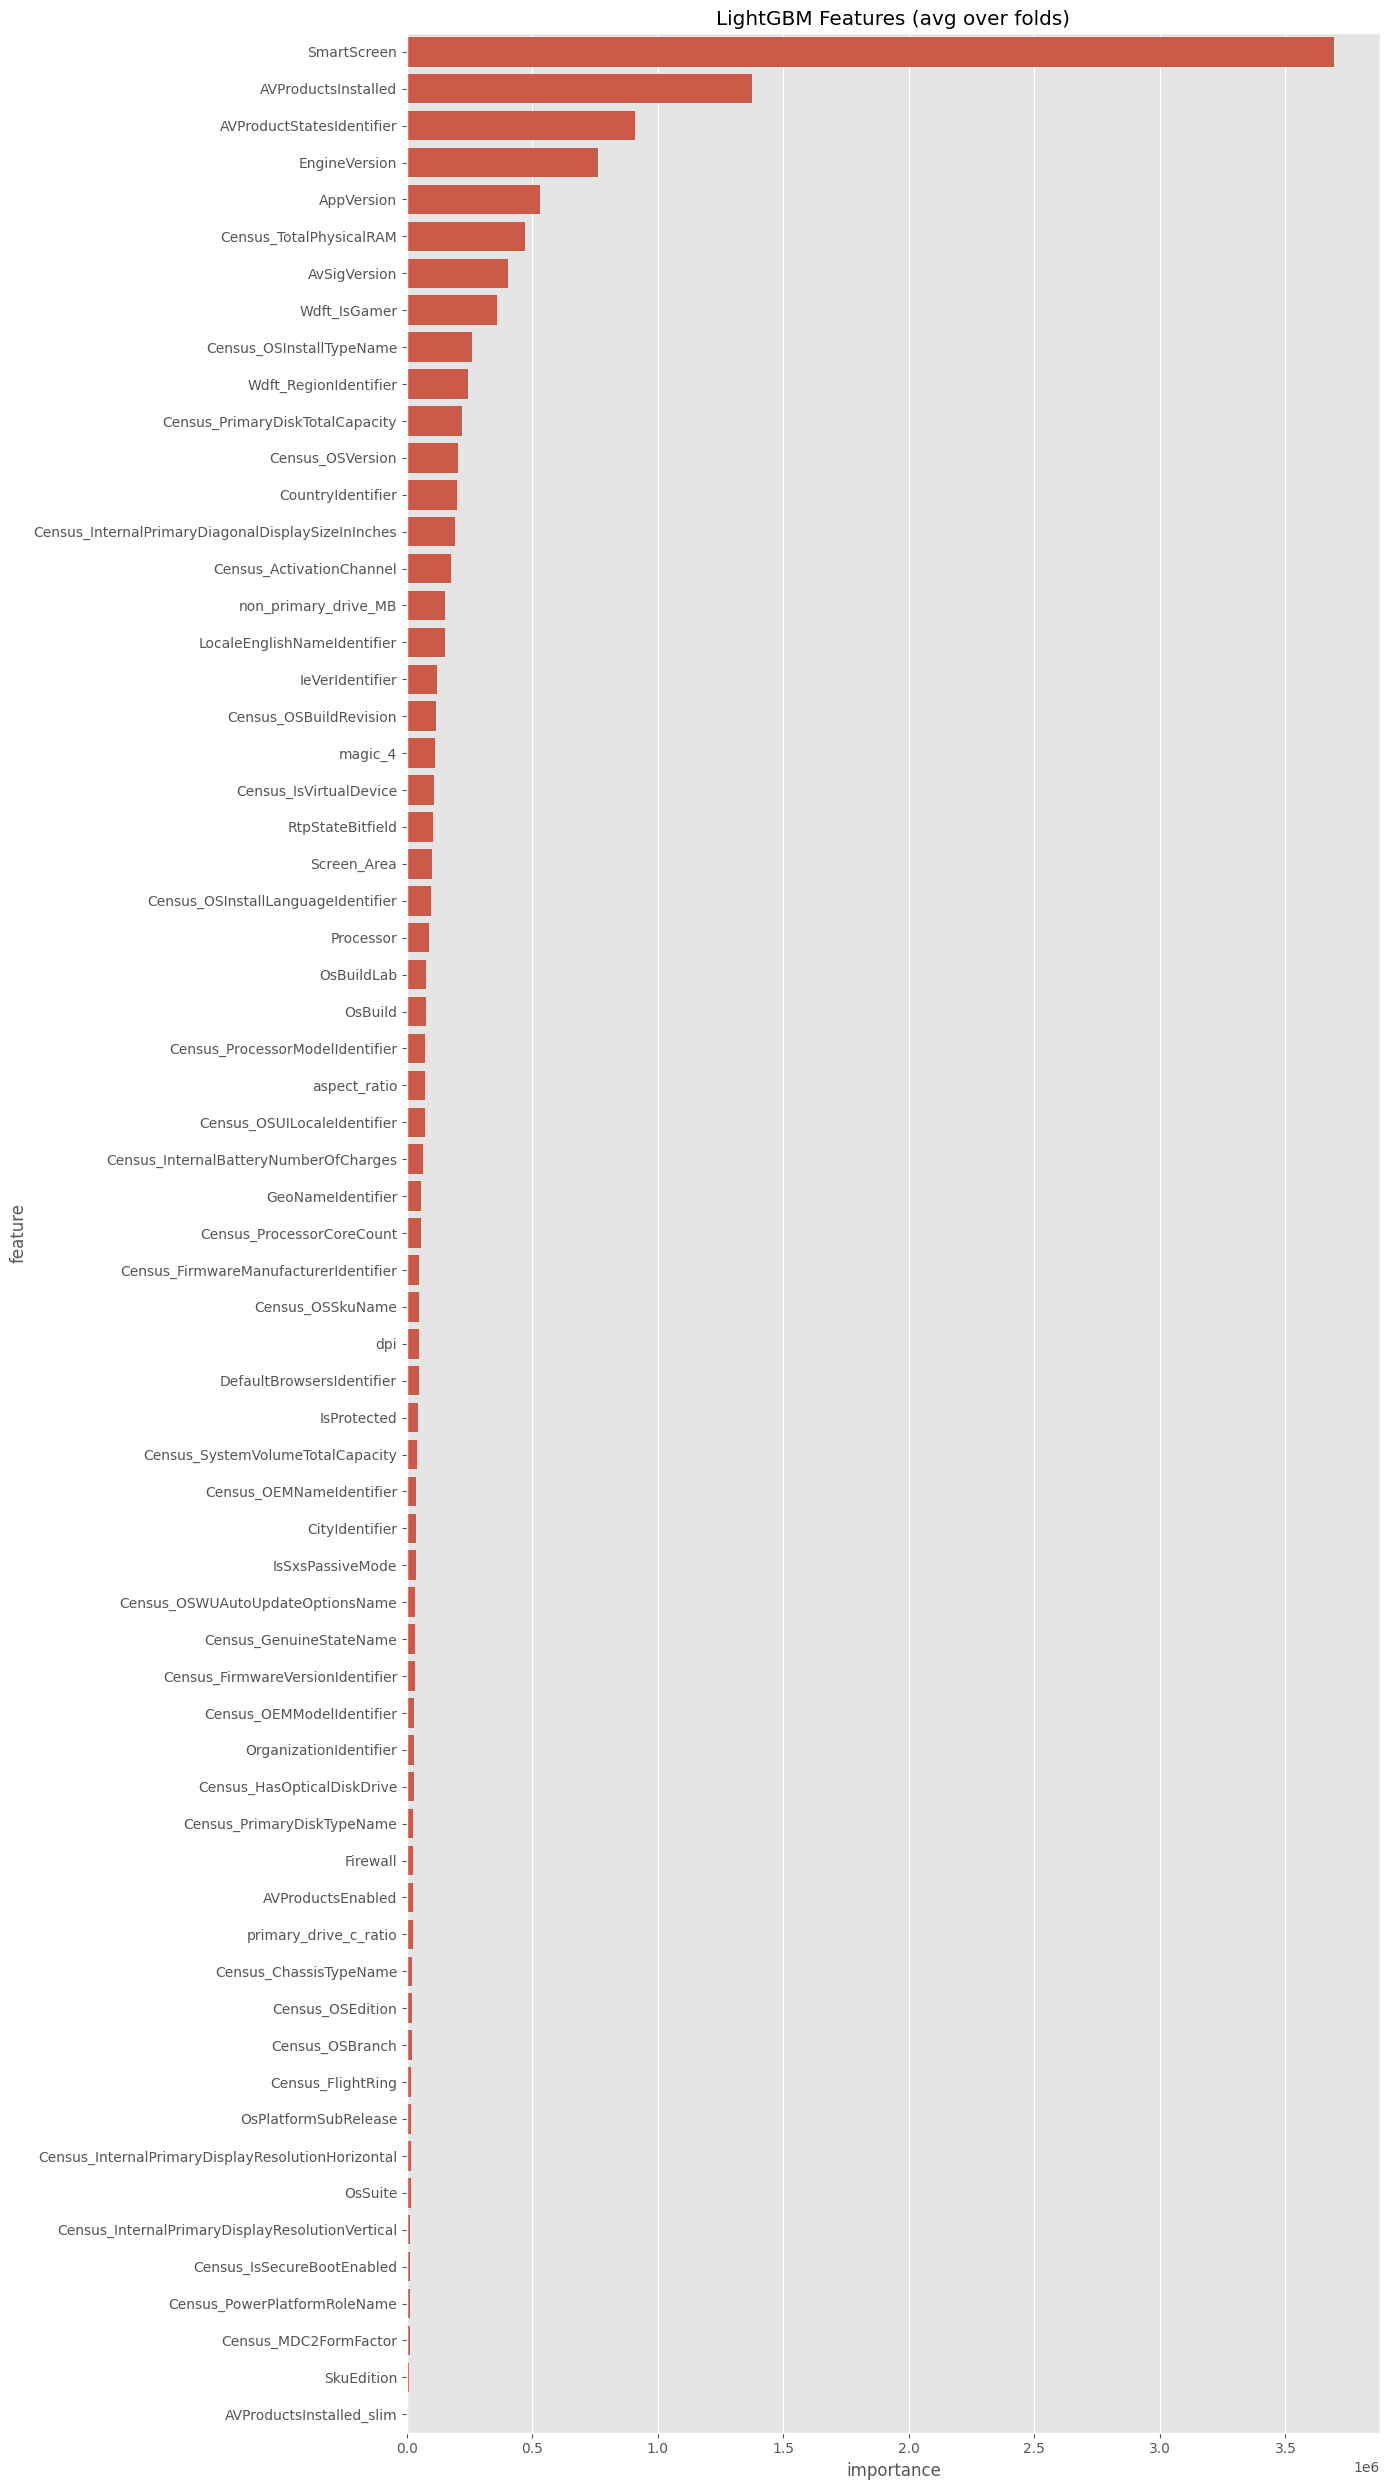

In [ ]:
stop_after_one_fold=True

random_state = 42

base_params = {   
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'nthread': 4,
        'learning_rate': 0.05,
        'max_depth': 5,
        'num_leaves': 40,
        'sub_feature': 0.9,
        'sub_row':0.9,
        'bagging_freq': 1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'random_state': random_state
        }

train_y = train['HasDetections']
models, validation_auc, validation_accuracy = train_model(train.drop(['HasDetections'], axis=1),
                                      train_y, base_params,
                                      num_round=2500,
                                      single_fold=stop_after_one_fold,
                                      save_feature_importances=True)



In [18]:
#save lgboost model
models[0].save_model('lgbm_model.model')